In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
from sklearn import linear_model
import os
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [4]:
def readJSON(path):
    f = gzip.open(path, 'rt', encoding='utf8')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d

In [5]:
answers = {}

In [6]:
# Some data structures that will be useful

gamesPerUser = defaultdict(set)
allGames = set()

In [7]:
allHours = []
for l in readJSON("data/train.json.gz"):
    allHours.append(l)

In [8]:
hoursTrain = allHours[:165000]
hoursValid = allHours[165000:]

In [9]:
##################################################
# Play prediction                                #
##################################################

In [10]:
# Any other preprocessing...

hoursValid[5]

('u35844632',
 'g92018877',
 {'hours': 1.2,
  'gameID': 'g92018877',
  'hours_transformed': 1.1375035237499351,
  'early_access': False,
  'date': '2015-11-22',
  'text': "I didn't understand a single thing, but it was a fun game!",
  'userID': 'u35844632'})

In [11]:
### Question 1

for h in allHours:
    uid = h[0]
    gid = h[1]
    gamesPerUser[uid].add(gid)
    allGames.add(gid)

In [12]:
# Random sampling

newValid = []
for h in hoursValid:
    uid = h[0]
    haveNotPlayed = []
    for g in allGames:
        if g not in gamesPerUser[uid]:
            haveNotPlayed.append(g)
    newValid.append((uid, h[1]))
    newValid.append((uid, random.choice(haveNotPlayed)))

In [13]:
# Evaluate baseline strategy

gameCount = defaultdict(int)
totalPlayed = 0

for user,game,_ in readJSON("data/train.json.gz"):
  gameCount[game] += 1
  totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

In [14]:
return1 = set()
count = 0
for ic, i in mostPopular:
  count += ic
  return1.add(i)
  if count > totalPlayed/2: break

In [15]:
newValid

[('u00914251', 'g61913894'),
 ('u00914251', 'g29034331'),
 ('u44824365', 'g16586637'),
 ('u44824365', 'g32003820'),
 ('u69168994', 'g51450658'),
 ('u69168994', 'g98961542'),
 ('u74934282', 'g45232069'),
 ('u74934282', 'g21020026'),
 ('u02906788', 'g36958384'),
 ('u02906788', 'g08978402'),
 ('u35844632', 'g92018877'),
 ('u35844632', 'g46602286'),
 ('u08586826', 'g36769937'),
 ('u08586826', 'g45024343'),
 ('u92465525', 'g01549519'),
 ('u92465525', 'g21091447'),
 ('u50690284', 'g05349653'),
 ('u50690284', 'g99934462'),
 ('u34690083', 'g08001721'),
 ('u34690083', 'g43188612'),
 ('u79438356', 'g04477361'),
 ('u79438356', 'g90153689'),
 ('u84107660', 'g11225866'),
 ('u84107660', 'g80627411'),
 ('u24256911', 'g67274965'),
 ('u24256911', 'g76099968'),
 ('u23937279', 'g31190276'),
 ('u23937279', 'g57658162'),
 ('u15844193', 'g55567630'),
 ('u15844193', 'g90348447'),
 ('u66008466', 'g12667678'),
 ('u66008466', 'g87968210'),
 ('u79801558', 'g27370047'),
 ('u79801558', 'g19831304'),
 ('u42207476',

In [16]:
'g61913894' in gamesPerUser['u00914251']

True

In [17]:
actual_q1 = []
pred_q1 = []

for pair in newValid:
    uid = pair[0]
    gid = pair[1]

    if gid in gamesPerUser[uid]:
        actual_q1.append(1)
    else:
        actual_q1.append(0)

    if gid in return1:
        pred_q1.append(1)
    else:
        pred_q1.append(0)

In [18]:
matches = 0

for i in range(len(actual_q1)):
    if actual_q1[i] == pred_q1[i]:
        matches += 1

acc_q1 = matches / len(actual_q1)

In [19]:
answers['Q1'] = acc_q1

In [20]:
assertFloat(answers['Q1'])

In [21]:
answers

{'Q1': 0.683968396839684}

In [22]:
### Question 2

In [23]:
# Improved strategy

def filterMostPopular(factor=1/2):
    output = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        output.add(i)
        if count > totalPlayed*factor: 
            return output

factors = [0.35, 0.40, 0.45, 0.5, 0.55]
for f in factors:
    return1 = filterMostPopular(f)

    pred = []
    for pair in newValid:
        uid = pair[0]
        gid = pair[1]

        if gid in return1:
            pred.append(1)
        else:
            pred.append(0)

    matches = 0
    for i in range(len(actual_q1)):
        if actual_q1[i] == pred[i]:
            matches += 1

    acc = matches / len(actual_q1)
    print(f"factor: {f}, acc: {acc}")

factor: 0.35, acc: 0.6454145414541455
factor: 0.4, acc: 0.6603160316031603
factor: 0.45, acc: 0.6745674567456745
factor: 0.5, acc: 0.683968396839684
factor: 0.55, acc: 0.6954195419541954


In [24]:
# Evaluate baseline strategy

return1 = filterMostPopular(0.55)

pred_q2 = []
for pair in newValid:
    uid = pair[0]
    gid = pair[1]

    if gid in return1:
        pred_q2.append(1)
    else:
        pred_q2.append(0)

matches = 0
for i in range(len(actual_q1)):
    if actual_q1[i] == pred_q2[i]:
        matches += 1

acc_q2 = matches / len(actual_q1)

In [25]:
answers['Q2'] = [totalPlayed*0.55, acc_q2]

In [26]:
answers

{'Q1': 0.683968396839684, 'Q2': [96249.45000000001, 0.6954195419541954]}

In [27]:
assertFloatList(answers['Q2'], 2)

In [28]:
### Question 3/4

In [29]:
def Jaccard(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    return intersection / union

In [30]:
# Useful data structures

playersPerGame = defaultdict(set)
gamesPerPlayer = defaultdict(set)

for h in hoursTrain:
    uid = h[0]
    gid = h[1]
    playersPerGame[gid].add(uid)
    gamesPerPlayer[uid].add(gid)

In [31]:
pred_q3 = []
all_sim = []

for h in newValid:
    uid = h[0]
    gid = h[1]
    played = gamesPerPlayer[uid]
    similarities = []
    for gid2 in played:
        sim = Jaccard(playersPerGame[gid], playersPerGame[gid2])
        similarities.append(sim)
        all_sim.append(sim)
    if max(similarities) > 0.030:
        pred_q3.append(1)
    else: 
        pred_q3.append(0)


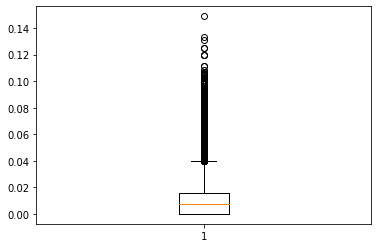

In [32]:
plt.boxplot(all_sim);

In [33]:
dummy = pd.DataFrame(data={'similarities': all_sim})
dummy.describe()

,similarities
count,736466.000000
mean,0.010517
std,0.011891
min,0.000000
25%,0.000000
50%,0.007407
75%,0.015909
max,0.148936


In [34]:
# Q3 accuracy

matches = 0
for i in range(len(actual_q1)):
    if actual_q1[i] == pred_q3[i]:
        matches += 1

acc_q3 = matches / len(actual_q1)

In [35]:
acc_q3

0.673067306730673

In [36]:
pred_q4 = []

return1 = filterMostPopular(0.55)

for h in newValid:
    uid = h[0]
    gid = h[1]
    played = gamesPerPlayer[uid]
    similarities = []
    for gid2 in played:
        sim = Jaccard(playersPerGame[gid], playersPerGame[gid2])
        similarities.append(sim)
    if max(similarities) > 0.03 and gid in return1:
        pred_q4.append(1)
    else: 
        pred_q4.append(0)

In [37]:
# Q4 accuracy

matches = 0
for i in range(len(actual_q1)):
    if actual_q1[i] == pred_q4[i]:
        matches += 1

acc_q4 = matches / len(actual_q1)

In [38]:
answers['Q3'] = acc_q3
answers['Q4'] = acc_q4

In [39]:
assertFloat(answers['Q3'])
assertFloat(answers['Q4'])

In [40]:
answers

{'Q1': 0.683968396839684,
 'Q2': [96249.45000000001, 0.6954195419541954],
 'Q3': 0.673067306730673,
 'Q4': 0.6867186718671867}

In [41]:
return1 = filterMostPopular(0.55)
predictions = open("HWpredictions_Played.csv", 'w')
for l in open("data/pairs_Played.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    
    # Logic...
    played = gamesPerPlayer[u]
    similarities = [0]
    for g2 in played:
        sim = Jaccard(playersPerGame[g], playersPerGame[g2])
        similarities.append(sim)
    if max(similarities) > 0.03 and g in return1:
        pred = 1
    else: 
        pred = 0
    
    _ = predictions.write(u + ',' + g + ',' + str(pred) + '\n')

predictions.close()

In [42]:
answers['Q5'] = "I confirm that I have uploaded an assignment submission to gradescope"

In [43]:
answers

{'Q1': 0.683968396839684,
 'Q2': [96249.45000000001, 0.6954195419541954],
 'Q3': 0.673067306730673,
 'Q4': 0.6867186718671867,
 'Q5': 'I confirm that I have uploaded an assignment submission to gradescope'}

In [44]:
##################################################
# Hours played prediction                        #
##################################################

In [45]:
trainHours = [r[2]['hours_transformed'] for r in hoursTrain]
globalAverage = sum(trainHours) * 1.0 / len(trainHours)

In [46]:
### Question 6

In [47]:
hoursPerUser = defaultdict(list)
hoursPerItem = defaultdict(list)

for h in hoursTrain:
    uid = h[0]
    gid = h[1]
    hoursTransformed = h[2]['hours_transformed']
    hoursPerUser[uid].append(hoursTransformed)
    hoursPerItem[gid].append(hoursTransformed)

In [50]:
betaU['u91746794']

6.356714460537184

In [51]:
alpha = globalAverage # Could initialize anywhere, this is a guess

In [52]:
list(betaU.values())[0]

1.2893185278431027

In [53]:
def MSE(actual, pred):
    return np.sum((actual-pred)**2) / len(actual)

In [55]:
alpha = globalAverage # Could initialize anywhere, this is a guess

In [232]:
betaU = {}
betaI = {}
for u in hoursPerUser:
    betaU[u] = 0

for g in hoursPerItem:
    betaI[g] = 0

In [197]:
trainHoursByPair = defaultdict(float)
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)

for h in hoursTrain:
    uid, gid, hours = h[0], h[1], h[2]['hours_transformed']
    trainHoursByPair[(uid, gid)] = hours
    itemsPerUser[uid].add(gid)
    usersPerItem[gid].add(uid)

In [200]:
# Alpha function
def calculate_alpha():
    numer = 0
    for pair in trainHoursByPair:
        u, g = pair[0], pair[1]
        numer += (trainHoursByPair[pair]-(betaU[u]+betaI[g]))
    denom = len(trainHours)
    return numer / denom

# BetaU function
def calculate_betaU(u, alpha, lamb):
    numer = 0
    for i in itemsPerUser[u]:
        numer += (trainHoursByPair[(u, i)]-(alpha+betaI[i]))
    denom = lamb + len(itemsPerUser[u])
    return numer / denom

# BetaI function
def calculate_betaI(i, alpha, lamb):
    numer = 0
    for u in usersPerItem[i]:
        numer += (trainHoursByPair[(u, i)]-(alpha+betaU[u]))
    denom = lamb + len(usersPerItem[i])
    return numer / denom

# Objective function
def calculate_objective(alpha, lamb):
    totalError = 0

    for pair in trainHoursByPair:
        pred = alpha + betaU[pair[0]] + betaI[pair[1]]
        actual = trainHoursByPair[pair]
        totalError += ((pred-actual)**2)

    regularizer = lamb*\
        (np.sum(np.array(list(betaU.values()))**2) + \
        np.sum(np.array(list(betaI.values()))**2))
        
    return totalError + regularizer

In [201]:
def iterate(lamb):

    # calculate alpha
    alpha_cd = calculate_alpha()

    # loop over users, calculate betaU, store in dictionary
    for p in hoursPerUser:
        bU_cd = calculate_betaU(p, alpha_cd, lamb)
        betaU[p] = bU_cd

    # loop over items, calculate betaI, store in dictionary
    for g in hoursPerItem:
        bI_cd = calculate_betaI(g, alpha_cd, lamb)
        betaI[g] = bI_cd

    return alpha_cd
        

In [233]:
# Coordinate Descent

objLog = {}
lastObjective = None
bestObjective = None
iterations = 1000
tol = 1e-5
lamb = 1

for iter in range(iterations):
    alpha_ = iterate(lamb)
    currObjective = calculate_objective(alpha_, lamb)
    print(f'Iteration {iter+1}: Loss = {currObjective}')
    if lastObjective and abs(lastObjective-currObjective) < tol:
        bestObjective = currObjective
        break
    lastObjective = currObjective
    objLog[iter+1] = currObjective

Iteration 1: Loss = 494437.2516434087
Iteration 2: Loss = 463123.9397682811
Iteration 3: Loss = 461721.85359065386
Iteration 4: Loss = 461607.19664067717
Iteration 5: Loss = 461577.1498817906
Iteration 6: Loss = 461553.6017012964
Iteration 7: Loss = 461531.0891837214
Iteration 8: Loss = 461509.2097913683
Iteration 9: Loss = 461487.9204430444
Iteration 10: Loss = 461467.20410987776
Iteration 11: Loss = 461447.04596912133
Iteration 12: Loss = 461427.43167515966
Iteration 13: Loss = 461408.34722511936
Iteration 14: Loss = 461389.77894268726
Iteration 15: Loss = 461371.7134712492
Iteration 16: Loss = 461354.1377680529
Iteration 17: Loss = 461337.0390985415
Iteration 18: Loss = 461320.40503067663
Iteration 19: Loss = 461304.22342929954
Iteration 20: Loss = 461288.4824504819
Iteration 21: Loss = 461273.1705359054
Iteration 22: Loss = 461258.2764073616
Iteration 23: Loss = 461243.78906110453
Iteration 24: Loss = 461229.69776245684
Iteration 25: Loss = 461215.99204024643
Iteration 26: Loss = 4

In [203]:
# MSE q6

actual_q6 = [h[2]['hours_transformed'] for h in hoursValid]
preds_q6 = []

for h in hoursValid:
    user, game = h[0], h[1]
    pred = alpha_ + betaU[user] + betaI[game]
    preds_q6.append(pred)

validMSE = MSE(np.array(actual_q6), np.array(preds_q6))

In [204]:
answers['Q6'] = validMSE

In [205]:
assertFloat(answers['Q6'])

In [206]:
answers

{'Q1': 0.683968396839684,
 'Q2': [96249.45000000001, 0.6954195419541954],
 'Q3': 0.673067306730673,
 'Q4': 0.6867186718671867,
 'Q5': 'I confirm that I have uploaded an assignment submission to gradescope',
 'Q6': 3.0073728449436676,
 'Q7': [6.475711427058052,
  -3.4530536681732302,
  5.060566989683245,
  -3.4578940441101294],
 'Q8': (1.3, 5.316020858071471)}

In [207]:
### Question 7

In [208]:
betaUs = [(betaU[u], u) for u in betaU]
betaIs = [(betaI[i], i) for i in betaI]
betaUs.sort()
betaIs.sort()

print("Maximum betaU = " + str(betaUs[-1][1]) + ' (' + str(betaUs[-1][0]) + ')')
print("Maximum betaI = " + str(betaIs[-1][1]) + ' (' + str(betaIs[-1][0]) + ')')
print("Minimum betaU = " + str(betaUs[0][1]) + ' (' + str(betaUs[0][0]) + ')')
print("Minimum betaI = " + str(betaIs[0][1]) + ' (' + str(betaIs[0][0]) + ')')

Maximum betaU = u60898505 (5.828516272137527)
Maximum betaI = g17604638 (5.513882931578414)
Minimum betaU = u13037838 (-3.0057164456685355)
Minimum betaI = g84397720 (-2.791543895327124)


In [209]:
answers['Q7'] = [betaUs[-1][0], betaUs[0][0], betaIs[-1][0], betaIs[0][0]]

In [210]:
answers['Q7']

[5.828516272137527, -3.0057164456685355, 5.513882931578414, -2.791543895327124]

In [211]:
assertFloatList(answers['Q7'], 4)

In [212]:
answers

{'Q1': 0.683968396839684,
 'Q2': [96249.45000000001, 0.6954195419541954],
 'Q3': 0.673067306730673,
 'Q4': 0.6867186718671867,
 'Q5': 'I confirm that I have uploaded an assignment submission to gradescope',
 'Q6': 3.0073728449436676,
 'Q7': [5.828516272137527,
  -3.0057164456685355,
  5.513882931578414,
  -2.791543895327124],
 'Q8': (1.3, 5.316020858071471)}

In [213]:
### Question 8

In [216]:
# Coordinate Descent

lambdas = [0.5, 1.5, 2]
mseDict = defaultdict(float)
iterations = 1000
tol = 1e-3

actual_q8 = [h[2]['hours_transformed'] for h in hoursValid]

for lamb in lambdas:
    lastObjective = None
    bestObjective = None

    betaU = {}
    betaI = {}
    for u in hoursPerUser:
        betaU[u] = 0
    for g in hoursPerItem:
        betaI[g] = 0

    for iter in range(iterations):
        alpha_ = iterate(lamb)
        currObjective = calculate_objective(alpha_, lamb)
        print(f'Iteration {iter+1}: Loss = {currObjective}')
        if lastObjective and abs(lastObjective-currObjective) < tol:
            bestObjective = currObjective
            break
        lastObjective = currObjective

    preds = []
    for h in hoursValid:
        user, game = h[0], h[1]
        pred = alpha_ + betaU[user] + betaI[game]
        preds.append(pred)

    mse = MSE(np.array(actual_q8), np.array(preds))
    mseDict[lamb] = mse
    if mse < validMSE:
        print("Found lamb with lower MSE!!!")
        break

Iteration 1: Loss = 492012.7909083451
Iteration 2: Loss = 459708.0365521542
Iteration 3: Loss = 458187.36394561816
Iteration 4: Loss = 458074.88363084715
Iteration 5: Loss = 458060.48007246025
Iteration 6: Loss = 458053.465785643
Iteration 7: Loss = 458047.0920641419
Iteration 8: Loss = 458040.84688122186
Iteration 9: Loss = 458034.69019834924
Iteration 10: Loss = 458028.6179332313
Iteration 11: Loss = 458022.6287656636
Iteration 12: Loss = 458016.7216002457
Iteration 13: Loss = 458010.89537081274
Iteration 14: Loss = 458005.14902497234
Iteration 15: Loss = 457999.48152258305
Iteration 16: Loss = 457993.8918356114
Iteration 17: Loss = 457988.3789479926
Iteration 18: Loss = 457982.9418554739
Iteration 19: Loss = 457977.57956560317
Iteration 20: Loss = 457972.2910975604
Iteration 21: Loss = 457967.0754820387
Iteration 22: Loss = 457961.9317612602
Iteration 23: Loss = 457956.858988755
Iteration 24: Loss = 457951.85622930503
Iteration 25: Loss = 457946.92255887116
Iteration 26: Loss = 4579

In [217]:
# Better lambda...

mseDict

defaultdict(float, {0.5: 3.013191503236919, 1.5: 3.002692000857554})

In [219]:
validMSE = list(mseDict.values())[1]

In [227]:
answers['Q8'] = (list(mseDict.keys())[1], validMSE)

In [228]:
assertFloatList(answers['Q8'], 2)

In [224]:
predictions = open("HWpredictions_Hours.csv", 'w')
for l in open("data/pairs_Hours.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    
    # Logic...
    alpha = alpha_
    bu, bi = betaU[u], betaI[g]
    
    _ = predictions.write(u + ',' + g + ',' + str(alpha + bu + bi) + '\n')

predictions.close()

In [229]:
answers

{'Q1': 0.683968396839684,
 'Q2': [96249.45000000001, 0.6954195419541954],
 'Q3': 0.673067306730673,
 'Q4': 0.6867186718671867,
 'Q5': 'I confirm that I have uploaded an assignment submission to gradescope',
 'Q6': 3.0073728449436676,
 'Q7': [5.828516272137527,
  -3.0057164456685355,
  5.513882931578414,
  -2.791543895327124],
 'Q8': (1.5, 3.002692000857554)}

In [230]:
f = open("answers_hw3.txt", 'w')
f.write(str(answers) + '\n')
f.close()

### Unused Code Archive

In [164]:
# trainHoursByPair = defaultdict(float)

# for h in hoursTrain:
#     uid, gid, hours = h[0], h[1], h[2]['hours_transformed']
#     trainHoursByPair[(uid, gid)] = hours

# lamb = 1

# # BetaU
# betaUs = defaultdict(float)
# for u in gamesPerPlayer:
#     numer = []
#     for g in gamesPerPlayer[u]:
#         diff = trainHoursByPair[(u, g)] - (a + betaI[g])
#         numer.append(diff)
#     oneBetaU = sum(numer) / (lamb + len(gamesPerPlayer[u]))
#     betaUs[u] = oneBetaU

# # BetaI
# betaIs = defaultdict(float)
# for g in playersPerGame:
#     numer = []
#     for u in playersPerGame[g]:
#         diff = trainHoursByPair[(u, g)] - (a + betaU[u])
#         numer.append(diff)
#     oneBetaI = sum(numer) / (lamb + len(playersPerGame[g]))
#     betaIs[g] = oneBetaI

# regularizer = lamb*(sum(np.array(list(betaUs.values()))**2) \
#     + sum(np.array(list(betaIs.values()))**2))

# optimBetas = None
# minError = None

# for bu in betaUs.values():
#     for bi in betaIs.values():
#         se = []
#         for pair in trainHoursByPair:
#             se.append((a + bu + bi - trainHoursByPair[pair])**2)
#         error = sum(se) + regularizer
#         if minError is None or minError > error:
#             minError = error
#             optimBetas = (bu, bi)

# u91746794

        # def gradient_descent(iter=1000, lr=0.0001, tol=1e-8, lamb=1):

        #     # Initializing
        #     curr_alpha = alpha
        #     # curr_betaU = np.mean(list(betaU.values()))
        #     curr_betaU = random.choice(list(betaU.values()))
        #     # curr_betaI = np.mean(list(betaI.values()))
        #     curr_betaI = random.choice(list(betaI.values()))

        #     losses = []
        #     prev_loss = None

        #     # Estimating optimal params
        #     for i in range(iter):
        #         # iter_loss = []
        #         for u in hoursPerUser:
        #             length = len(hoursPerUser[u])
        #             actualHours = np.array(hoursPerUser[u])

        #             pred = [curr_alpha + curr_betaU + curr_betaI]*length
        #             # loss_bu = MSE(actualHours, np.array(pred))
        #             # loss.append(loss_bu)

        #             betaU_derivative = \
        #                 2*np.sum(np.array(pred)-actualHours) + 2*lamb*curr_betaU
                    
        #             next_betaU = curr_betaU - (lr * betaU_derivative)

        #             if abs(next_betaU - curr_betaU) < tol:
        #                 break

        #             curr_betaU = next_betaU

        #         for g in hoursPerItem:
        #             length = len(hoursPerItem[g])
        #             actualHours = np.array(hoursPerItem[g])

        #             pred = [curr_alpha + curr_betaU + curr_betaI]*length
        #             # loss_bi = MSE(actualHours, np.array(pred))
        #             # loss.append(loss_bi)

        #             betaI_derivative = \
        #                 2*np.sum(np.array(pred)-actualHours) + 2*lamb*curr_betaI
                    
        #             next_betaI = curr_betaI - (lr * betaI_derivative)

        #             if abs(next_betaI - curr_betaI) < tol:
        #                 break

        #             curr_betaI = next_betaI
                
        #         # Updating alpha
        #         length = len(trainHours)
        #         pred = [curr_alpha + curr_betaU + curr_betaI]*length
        #         # curr_loss = MSE(np.array(trainHours), np.array(pred))
        #         # iter_loss.append(loss)

        #         curr_loss = np.sum((np.array(pred)-np.array(trainHours))**2) + \
        #             lamb*(np.sum(np.array(list(betaU.values()))**2) + np.sum(np.array(list(betaI.values()))**2))

        #         alpha_derivative = \
        #             2*np.sum(np.array(pred)-np.array(trainHours))

        #         next_alpha = curr_alpha - (lr * alpha_derivative)

        #         # if np.sum(np.isnan(iter_loss)) > 0:
        #         #     nonNullLosses = []
        #         #     for l in loss:
        #         #         if not np.isnan(l):
        #         #             nonNullLosses.append(l)
                
        #         # curr_loss = np.mean(nonNullLosses)

        #         print(f"Iteration {i+1}: Loss {curr_loss}")

        #         # if prev_loss and abs(prev_loss-curr_loss) <= tol:
        #         if abs(next_alpha - curr_alpha) < tol:
        #             break

        #         prev_loss = curr_loss
        #         losses.append(curr_loss)
        #         curr_alpha = next_alpha

        #         # if i == 55: break

        #     return curr_alpha, curr_betaU, curr_betaI


# # Coordinate Descent

# objLog = []
# lastObjective = None
# bestObjective = None
# iterations = 100
# tol = 1e-5
# lamb = 1
# bu = 0
# bi = 0

# for iter in range(iterations):
#     alpha_cd = calculate_alpha(bu, bi)

#     if bestObjective is None:
#         bestObjective = calculate_objective(alpha_cd, bu, bi, lamb)
#         print(bestObjective)

#     for p in hoursPerUser:
#         bU_cd = calculate_betaU(p, alpha_cd, bi, lamb)
#         newObjective = calculate_objective(alpha_cd, bU_cd, bi, lamb)

#         if newObjective < bestObjective:
#             bu = bU_cd
#             bestObjective = newObjective
    
#     for g in hoursPerItem:
#         bI_cd = calculate_betaI(g, alpha_cd, bu, lamb)
#         newObjective = calculate_objective(alpha_cd, bu, bI_cd, lamb)

#         if newObjective < bestObjective:
#             bi = bI_cd
#             bestObjective = newObjective

#     # if lastObjective and abs(lastObjective-bestObjective) < tol:
#     #     break

#     lastObjective = bestObjective
#     objLog.append(lastObjective)

#     print(f'Iteration {iter+1}: Objective = {bestObjective}')

# userEncoder = {}

# counter = 0
# for u in hoursPerUser:
#     encoder = [0]*(len(hoursPerUser)-1)
#     if counter > 0:
#         encoder[counter-1] = 1
#     userEncoder[u] = encoder
#     counter += 1

# itemEncoder = {}

# counter = 0
# for g in hoursPerItem:
#     encoder = [0]*(len(hoursPerItem)-1)
#     if counter > 0:
#         encoder[counter-1] = 1
#     itemEncoder[g] = encoder
#     counter += 1

# X = [[1]+userEncoder[u[0]]+itemEncoder[u[1]] for u in trainHoursByPair]
# y = trainHours
# mdl = linear_model.SGDRegressor(fit_intercept=False, alpha=1)
# mdl.fit(X, y)
# preds_sklearn = mdl.predict(X[:5])
# mse_sklearn = MSE(np.array(trainHours[:5]), preds_sklearn)

# x2 = [[1, 1, 1]]*len(trainHours)
# mdl2 = linear_model.SGDRegressor(fit_intercept=False)
# mdl2.fit(x2, y)
# preds2 = mdl2.predict(x2)
# mse_sklearn2 = MSE(np.array(trainHours), preds2)